# DRIVER DROWSINESS DETECTION SYSTEM****

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import load_img
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D

2024-03-26 20:42:43.417187: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 20:42:43.417306: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 20:42:43.655446: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
TRAIN_DIR = '/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/'
TEST_DIR = '/kaggle/input/driver-drowsiness-dataset-ddd/Driver Drowsiness Dataset (DDD)/'

In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels
## convert into dataframe
train = pd.DataFrame()

In [4]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

Non Drowsy Completed
Drowsy Completed


,image,label
0,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy
1,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Drowsy
2,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Drowsy
3,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy
4,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy


In [5]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

Non Drowsy Completed
Drowsy Completed


,image,label
0,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy
1,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy
2,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy
3,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy
4,/kaggle/input/driver-drowsiness-dataset-ddd/Dr...,Non Drowsy


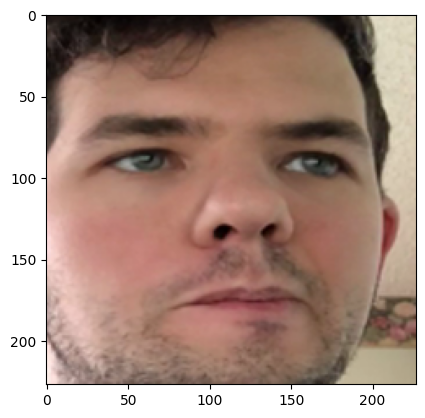

In [6]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

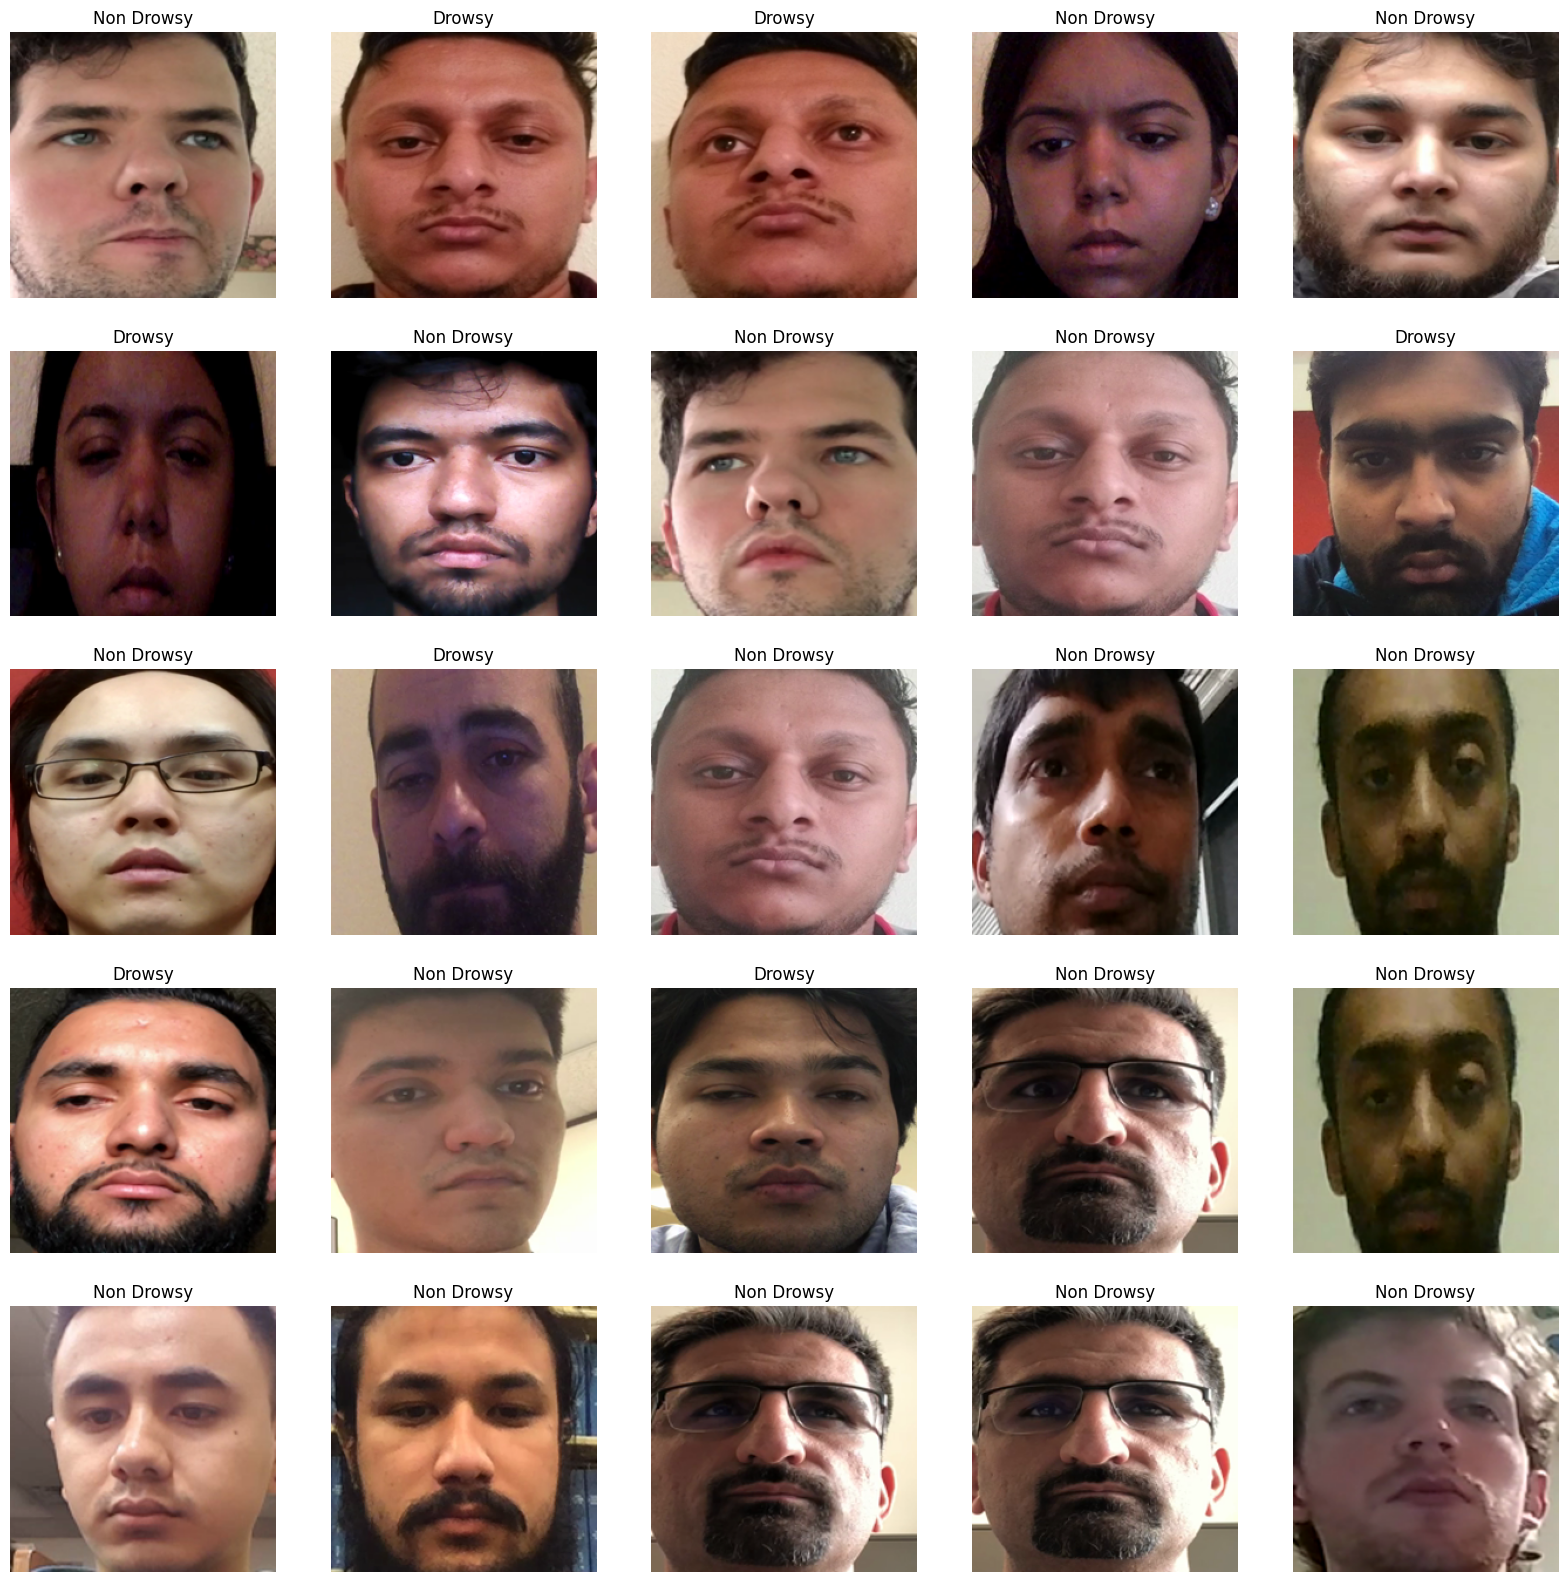

In [7]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        img = load_img(image, color_mode="rgb")
        img = img.resize((48, 48))  # Resize the image to a consistent size
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    return features


In [10]:
train_features = extract_features(train['image'])

  0%|          | 0/41793 [00:00<?, ?it/s]

In [11]:
test_features = extract_features(test['image'])

  0%|          | 0/41793 [00:00<?, ?it/s]

In [12]:
x_train = train_features/255.0
x_test = test_features/255.0

In [14]:
## convert label to integer
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [15]:
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

In [16]:
y_train[0]

array([0., 1.])

In [17]:
# configure
input_shape = (48, 48, 3)
output_class = 2

In [18]:
model = Sequential()
# convolutional layers
model.add(Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))
model.add(Flatten())
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
# output layer
model.add(Dense(output_class, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
#training the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
  3/327 ━━━━━━━━━━━━━━━━━━━━ 17s 55ms/step - accuracy: 0.5464 - loss: 0.7504 

I0000 00:00:1711487106.614526      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711487106.634761      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


327/327 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.6639 - loss: 0.5500

W0000 00:00:1711487132.221421      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1711487135.949776      91 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


327/327 ━━━━━━━━━━━━━━━━━━━━ 55s 102ms/step - accuracy: 0.6644 - loss: 0.5493 - val_accuracy: 0.9982 - val_loss: 0.0095
Epoch 2/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9914 - loss: 0.0299 - val_accuracy: 0.9991 - val_loss: 0.0034
Epoch 3/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 15s 47ms/step - accuracy: 0.9969 - loss: 0.0105 - val_accuracy: 0.9999 - val_loss: 7.4603e-04
Epoch 4/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9971 - loss: 0.0099 - val_accuracy: 0.9996 - val_loss: 9.6424e-04
Epoch 5/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 16s 48ms/step - accuracy: 0.9977 - loss: 0.0074 - val_accuracy: 0.9999 - val_loss: 7.4821e-04
Epoch 6/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9978 - loss: 0.0078 - val_accuracy: 0.9990 - val_loss: 0.0033
Epoch 7/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 16s 49ms/step - accuracy: 0.9979 - loss: 0.0072 - val_accuracy: 0.9997 - val_loss: 0.0011
Epoch 8/50
327/327 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.9964 - loss: 0.0118 

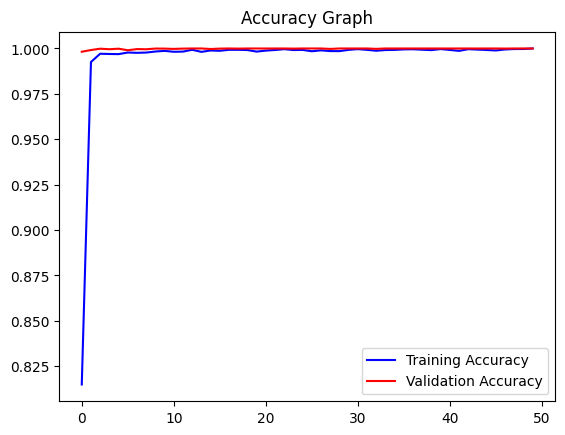

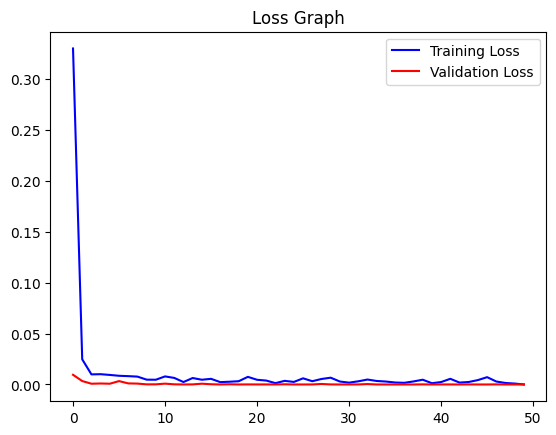

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

Original Output: Drowsy
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Output: Drowsy


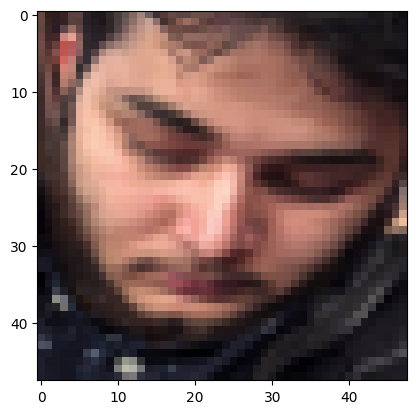

In [21]:
image_index = random.randint(0, len(test))
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 3))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48, 3), cmap='gray');


Original Output: Non Drowsy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted Output: Non Drowsy


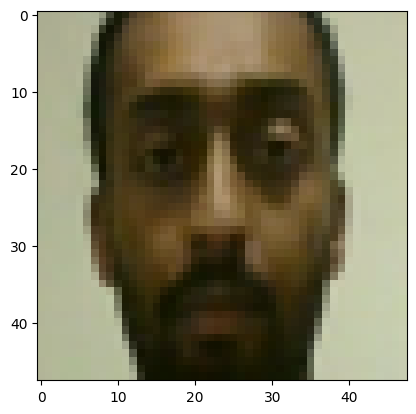

In [22]:
image_index = 0  # Specify the index of the image you want to predict
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 3))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48, 3), cmap='gray');
